In [ ]:
#!pip install duckdb
#!pip install pandas
#!pip install geopandas
#!pip install sklearn
#!pip install matplotlib
#!pip install seaborn


Python(13197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [17]:
import duckdb
import os
import glob
import pandas as pd
import re
import math
import gc
import time

In [18]:
# === CONFIGURACIÓN ===
CARPETA_DATOS = r"/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral"
ARCHIVO_SALIDA = os.path.join(CARPETA_DATOS, "Delegacion_comb.parquet")

# === BUSCAR ARCHIVOS PARQUET (recursivamente) ===
archivos_parquet = [
    f for f in glob.glob(os.path.join(CARPETA_DATOS, "**", "*.parquet"), recursive=True)
    if not f.endswith(".crc")
]

if not archivos_parquet:
    print("❌ No se encontraron archivos .parquet.")
else:
    print(f"✅ Se encontraron {len(archivos_parquet)} archivos Parquet.")
    
    # === CONECTAR A DUCKDB (sin archivo .db, todo en memoria) ===
    con = duckdb.connect()

    # === LEER Y COMBINAR ===
    # DuckDB entiende patrones tipo *.parquet y concatena automáticamente.
    # Usamos UNION ALL para concatenar todos los archivos.
    query = f"""
        COPY (
            SELECT * FROM read_parquet({archivos_parquet})
        )
        TO '{ARCHIVO_SALIDA}'
        (FORMAT PARQUET, COMPRESSION 'SNAPPY');
    """

    print("\n⏳ Combinando archivos...")
    con.execute(query)
    con.close()

    print(f"\n💾 Parquet combinado guardado en:\n{ARCHIVO_SALIDA}")


✅ Se encontraron 33 archivos Parquet.

⏳ Combinando archivos...

💾 Parquet combinado guardado en:
/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb.parquet


In [19]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [20]:
archivos = [
    f for f in glob.glob(os.path.join(CARPETA_DATOS, "**", "*.parquet"), recursive=True)
    if not f.endswith(".crc") and not f.endswith("Delegacion_comb.parquet")
]

con = duckdb.connect()

# Total de filas en todos los archivos originales
total_originales = con.execute(f"SELECT SUM(count) FROM (SELECT COUNT(*) AS count FROM read_parquet({archivos}) GROUP BY filename)").fetchone()[0]

# Total en el combinado
total_combinado = con.execute(f"SELECT COUNT(*) FROM read_parquet('{ARCHIVO_SALIDA}')").fetchone()[0]



print(f"\n✅ Total original:  {total_originales:,}")
print(f"✅ Total combinado: {total_combinado:,}")
print("🎯 Coinciden" if total_originales == total_combinado else "⚠️ No coinciden, revisa los archivos.")

# Ver las columnas y tipos
print("\n🧱 Esquema:")
print(con.execute(f"DESCRIBE SELECT * FROM read_parquet('{ARCHIVO_SALIDA}')").fetchdf())


con.close()



✅ Total original:  1,469,677
✅ Total combinado: 1,469,677
🎯 Coinciden

🧱 Esquema:
              column_name column_type null   key default extra
0                     fid      DOUBLE  YES  None    None  None
1                   fid_2      DOUBLE  YES  None    None  None
2            calle_numero     VARCHAR  YES  None    None  None
3           codigo_postal     VARCHAR  YES  None    None  None
4                 colonia     VARCHAR  YES  None    None  None
5                alcaldia     VARCHAR  YES  None    None  None
6             sup_terreno      DOUBLE  YES  None    None  None
7        sup_construccion      DOUBLE  YES  None    None  None
8       anio_construccion      DOUBLE  YES  None    None  None
9              instal_esp      BIGINT  YES  None    None  None
10   valor_unitario_suelo      DOUBLE  YES  None    None  None
11            valor_suelo      DOUBLE  YES  None    None  None
12                cve_vus     VARCHAR  YES  None    None  None
13               subsidio      DOUB

Utilizaré "ageb_lon" y "ageb_lat" para hacer el merge con las otras basesde datos.
Antes quitaré los nulos de mi base final

In [21]:
ARCHIVO = r"/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb.parquet"
con = duckdb.connect()

stats = con.execute(f"""
SELECT
  COUNT(*) AS total,
  SUM(CASE WHEN ageb_lon IS NULL OR ageb_lat IS NULL THEN 1 ELSE 0 END) AS sin_coordenadas,
  SUM(CASE WHEN ageb_lon IS NOT NULL AND ageb_lat IS NOT NULL THEN 1 ELSE 0 END) AS con_coordenadas
FROM read_parquet('{ARCHIVO}')
""").fetchdf()

print(stats)

con.close()

     total  sin_coordenadas  con_coordenadas
0  1469677             25.0        1469652.0


In [22]:
CARPETA_DATOS = r"/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral"
ARCHIVO_ORIGINAL = os.path.join(CARPETA_DATOS, "Delegacion_comb.parquet")
ARCHIVO_FILTRADO = os.path.join(CARPETA_DATOS, "Delegacion_comb_filtrado.parquet")

con = duckdb.connect()

# Crear una nueva versión filtrada (sin valores nulos en lat/lon)
query = f"""
COPY (
    SELECT *
    FROM read_parquet('{ARCHIVO_ORIGINAL}')
    WHERE ageb_lon IS NOT NULL AND ageb_lat IS NOT NULL
)
TO '{ARCHIVO_FILTRADO}' (FORMAT PARQUET, COMPRESSION 'SNAPPY');
"""

print("⏳ Filtrando datos...")
con.execute(query)

# Verificar resultado
result = con.execute(f"SELECT COUNT(*) FROM read_parquet('{ARCHIVO_FILTRADO}')").fetchone()[0]
print(f"✅ Filtrado completo. Total de filas con coordenadas: {result:,}")

con.close()


⏳ Filtrando datos...
✅ Filtrado completo. Total de filas con coordenadas: 1,469,652


Ahora cambiare el formato de las latitudes y longitudes del Concat de las delegaciones. de INEGI (EPSG:6372) → WGS84 (EPSG:4326)

In [23]:
from pyproj import Transformer
from shapely.geometry import Point

In [24]:
ageb_path = "/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb_filtrado.parquet"

In [25]:
# ============================================
# CONVERSIÓN DE COORDENADAS INEGI (CCL ITRF2008) → WGS84
# ============================================

# === 1️⃣ CONFIGURACIÓN ===
parquet_path = r"/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb_filtrado.parquet"
output_path = r"/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb_filtrado_wgs84.parquet"


In [26]:
# === 2️⃣ LEER PARQUET ===
print(f"📦 Cargando archivo Parquet: {parquet_path}")
df_ageb = pd.read_parquet(parquet_path)
print(f"✅ Archivo cargado: {df_ageb.shape[0]:,} filas, {df_ageb.shape[1]} columnas")

📦 Cargando archivo Parquet: /Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb_filtrado.parquet
✅ Archivo cargado: 1,469,652 filas, 151 columnas


In [27]:
# === 3️⃣ CREAR TRANSFORMADOR ===
# INEGI usa Lambert Cónica Conforme ITRF2008 = EPSG:6372
transformer = Transformer.from_crs("EPSG:6372", "EPSG:4326", always_xy=True)

In [28]:
# === 4️⃣ VALIDAR COLUMNAS ===
# Ajusta si tus columnas tienen otros nombres
if not {"ageb_lon", "ageb_lat"}.issubset(df_ageb.columns):
    raise ValueError("❌ El archivo debe tener columnas llamadas 'ageb_lon' y 'ageb_lat'.")

# === 5️⃣ FILTRAR FILAS VÁLIDAS ===
mask_valid = df_ageb["ageb_lon"].notna() & df_ageb["ageb_lat"].notna()
print(f"📍 Filas válidas con coordenadas: {mask_valid.sum():,}")

📍 Filas válidas con coordenadas: 1,469,652


In [29]:
# === 6️⃣ TRANSFORMAR COORDENADAS ===
lon_wgs84, lat_wgs84 = transformer.transform(
    df_ageb.loc[mask_valid, "ageb_lon"].astype(float).values,
    df_ageb.loc[mask_valid, "ageb_lat"].astype(float).values
)

In [30]:
# === 7️⃣ CREAR NUEVAS COLUMNAS ===
df_ageb["lon_wgs84"] = pd.NA
df_ageb["lat_wgs84"] = pd.NA
df_ageb.loc[mask_valid, "lon_wgs84"] = lon_wgs84
df_ageb.loc[mask_valid, "lat_wgs84"] = lat_wgs84

# === 8️⃣ VISTA PREVIA ===
print("\n🔍 Ejemplo de coordenadas transformadas:")
print(df_ageb[["ageb_lon", "ageb_lat", "lon_wgs84", "lat_wgs84"]].head(10))


🔍 Ejemplo de coordenadas transformadas:
       ageb_lon       ageb_lat  lon_wgs84  lat_wgs84
0  2.800048e+06  845015.333800 -99.131257  19.577183
1  2.800048e+06  845015.333800 -99.131257  19.577183
2  2.800006e+06  844827.171348 -99.131691  19.575486
3  2.800006e+06  844827.171348 -99.131691  19.575486
4  2.800955e+06  843250.986300 -99.122927  19.561034
5  2.800006e+06  844827.171348 -99.131691  19.575486
6  2.800006e+06  844827.171348 -99.131691  19.575486
7  2.800006e+06  844827.171348 -99.131691  19.575486
8  2.800006e+06  844827.171348 -99.131691  19.575486
9  2.800006e+06  844827.171348 -99.131691  19.575486


In [31]:
# === 9️⃣ GUARDAR PARQUET ACTUALIZADO ===
# Usa compresión Snappy (por defecto) para eficiencia
df_ageb.to_parquet(output_path, index=False)
print(f"\n✅ Archivo guardado con coordenadas WGS84 en: {output_path}")
print("   Columnas agregadas: 'lon_wgs84', 'lat_wgs84'")


✅ Archivo guardado con coordenadas WGS84 en: /Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb_filtrado_wgs84.parquet
   Columnas agregadas: 'lon_wgs84', 'lat_wgs84'


Voy a renombrar las columnas de los archivos csv de los puntos de interes

In [36]:
# === CONFIGURACIÓN ===
RUTA_BASE = r"/Users/eaha/Documents/TFM/mlops-repo/data/processed/csv"
SOBREESCRIBIR = True 

In [37]:
# Posibles nombres de columnas para detección flexible
NOMBRES_LATITUD = ["lat", "latitude", "latitud", "y"]
NOMBRES_LONGITUD = ["lon", "long", "longitude", "longitud", "x"]

In [38]:
# === FUNCIÓN PRINCIPAL ===
def renombrar_columnas_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
    except Exception as e:
        print(f"❌ No se pudo leer {ruta_csv}: {e}")
        return

    columnas_originales = list(df.columns)
    columnas_lower = [c.strip().lower() for c in columnas_originales]

    renombrar = {}

    # Buscar equivalencias en nombres de columnas
    for i, nombre in enumerate(columnas_lower):
        if nombre in [n.lower() for n in NOMBRES_LATITUD]:
            renombrar[columnas_originales[i]] = "latitud"
        elif nombre in [n.lower() for n in NOMBRES_LONGITUD]:
            renombrar[columnas_originales[i]] = "longitud"

    if renombrar:
        print(f"\n📄 Procesando: {os.path.basename(ruta_csv)}")
        print(f"🔁 Renombrando columnas: {renombrar}")
        df.rename(columns=renombrar, inplace=True)

        # Guardar sobrescribiendo
        df.to_csv(ruta_csv, index=False)
        print(f"✅ Archivo sobrescrito: {ruta_csv}")

        # Validar coordenadas si existen ambas columnas
        if "latitud" in df.columns and "longitud" in df.columns:
            try:
                lat_min, lat_max = df["latitud"].min(), df["latitud"].max()
                lon_min, lon_max = df["longitud"].min(), df["longitud"].max()

                print(f"📊 Rango latitud:  {lat_min:.6f} → {lat_max:.6f}")
                print(f"📊 Rango longitud: {lon_min:.6f} → {lon_max:.6f}")

                # Detección básica de formato
                if abs(lat_min) > 90 or abs(lat_max) > 90 or abs(lon_min) > 180 or abs(lon_max) > 180:
                    print("⚠️ Coordenadas fuera de rango típico (posiblemente en metros o en proyección).")
                else:
                    print("✅ Coordenadas parecen estar en grados geográficos (WGS84).")
            except Exception as e:
                print(f"⚠️ No se pudo calcular rango de coordenadas: {e}")
        else:
            print("⚠️ No se encontraron ambas columnas de latitud y longitud después del renombrado.")
    else:
        print(f"⚠️ No se detectaron columnas para renombrar en {os.path.basename(ruta_csv)}.")



In [39]:
# === RECORRER SUBCARPETAS Y APLICAR ===
for root, _, files in os.walk(RUTA_BASE):
    for file in files:
        if file.lower().endswith(".csv"):
            ruta_completa = os.path.join(root, file)
            renombrar_columnas_csv(ruta_completa)


⚠️ No se detectaron columnas para renombrar en cdmx_areas_verdes_2017.csv.

📄 Procesando: areas_verdes_filtrado.csv
🔁 Renombrando columnas: {'latitud': 'latitud', 'longitud': 'longitud'}
✅ Archivo sobrescrito: /Users/eaha/Documents/TFM/mlops-repo/data/processed/csv/areas_verdes_filtrado.csv
📊 Rango latitud:  19.173251 → 19.562414
📊 Rango longitud: -99.331159 → -98.962573
✅ Coordenadas parecen estar en grados geográficos (WGS84).

📄 Procesando: escuelas_publicas.csv
🔁 Renombrando columnas: {'latitud': 'latitud', 'longitud': 'longitud'}
✅ Archivo sobrescrito: /Users/eaha/Documents/TFM/mlops-repo/data/processed/csv/escuelas_publicas.csv
📊 Rango latitud:  19.169883 → 19.577081
📊 Rango longitud: -99.334459 → -98.951824
✅ Coordenadas parecen estar en grados geográficos (WGS84).

📄 Procesando: escuelas_privadas_con_coordenadas.csv
🔁 Renombrando columnas: {'lon': 'longitud', 'lat': 'latitud'}
✅ Archivo sobrescrito: /Users/eaha/Documents/TFM/mlops-repo/data/processed/csv/escuelas_privadas/escue

Ahora ya tengo listos todos mis data sets, procederé a realizar el merge de mi archivo 
Delegacion_comb_filtrado_wgs84.parquet como base y agregarle los datos de todos los otros csv que encontramos

In [40]:
import os
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

In [ ]:
# ============== CONFIGURACIÓN ==============
base_parquet = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Delegacion_comb_filtrado_wgs84.parquet")
carpeta_csvs = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/csv")
csvs_interes = [
    "escuelas_privadas/escuelas_privadas_con_coordenadas.csv",
    "hospitales_y_centros_de_salud/hospitales_y_centros_de_salud_con_coordenadas.csv",
    "mb_shp/Metrobus_estaciones_con_coordenadas.csv",
    "stcmetro_shp/STC_Metro_estaciones_utm14n_con_coordenadas.csv",
    "areas_verdes_filtrado.csv",
    "escuelas_publicas.csv"
]
output_dir = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/tmp_chunks_balltree")
output_dir.mkdir(parents=True, exist_ok=True)

output_final = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet")


In [42]:
chunk_size = 50_000           # ajusta si te hace falta menos RAM (p.ej. 20_000)
max_distance_km = 5.0         # radio de match
R_EARTH_M = 6_371_000.0       # radio tierra (m)
max_distance_m = max_distance_km * 1000.0
max_distance_rad = max_distance_m / R_EARTH_M  # para métrica haversine

In [43]:
# ============== CARGAR BASE ==============
# Usamos DuckDB solo para leer la base en chunks (pandas no streamea parquet por filas fácilmente)
con = duckdb.connect()
n_rows = con.execute(f"SELECT COUNT(*) FROM read_parquet('{base_parquet.as_posix()}')").fetchone()[0]
print(f"📦 Archivo base: {n_rows:,} filas")

# Validaciones mínimas
sample = con.execute(f"SELECT * FROM read_parquet('{base_parquet.as_posix()}') LIMIT 1").fetchdf()
if not {"lon_wgs84", "lat_wgs84"}.issubset(sample.columns):
    raise ValueError("❌ El archivo base debe tener columnas 'lon_wgs84' y 'lat_wgs84'.")

📦 Archivo base: 1,469,652 filas


In [44]:
# ============== PREPARAR CSVs (índice BallTree por archivo) ==============
csv_models = []  # lista de dicts: {alias, df, tree, coords_rad, cols_out}
for rel in csvs_interes:
    csv_path = (carpeta_csvs / rel).resolve()
    alias = csv_path.stem.lower().replace(" ", "_")
    if not csv_path.exists():
        print(f"⚠️ CSV no encontrado, se omite: {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    # Validar columnas esperadas
    if not {"latitud", "longitud"}.issubset(df.columns):
        print(f"⚠️ {csv_path.name} no tiene columnas 'latitud' y 'longitud'. Se omite.")
        continue

    # Filtrar filas con coordenadas válidas
    df = df.loc[df["latitud"].notna() & df["longitud"].notna()].copy()
    if df.empty:
        print(f"⚠️ {csv_path.name} sin coordenadas válidas. Se omite.")
        continue

    # Sufijos: renombrar TODAS las columnas del CSV (incluyendo lat/long) para evitar colisiones
    rename_map = {col: f"{col}_{alias}" for col in df.columns}
    df = df.rename(columns=rename_map)

    # Coordenadas en radianes (orden lat, lon para haversine)
    coords_deg = df[[f"latitud_{alias}", f"longitud_{alias}"]].astype(float).values
    coords_rad = np.radians(coords_deg)
    # BallTree con métrica haversine
    tree = BallTree(coords_rad, metric="haversine")

    # Guardar modelo del CSV
    csv_models.append({
        "alias": alias,
        "df": df,                    # dataframe con columnas ya sufijadas
        "tree": tree,
        "coords_rad": coords_rad,
        "cols_out": df.columns.tolist()  # todas las columnas del CSV (sufijadas)
    })
    print(f"🛠️ Índice listo: {alias} ({len(df):,} puntos)")

if not csv_models:
    raise RuntimeError("No hay CSVs válidos para procesar.")

🛠️ Índice listo: escuelas_privadas_con_coordenadas (3,659 puntos)
🛠️ Índice listo: hospitales_y_centros_de_salud_con_coordenadas (27 puntos)
🛠️ Índice listo: metrobus_estaciones_con_coordenadas (324 puntos)
🛠️ Índice listo: stc_metro_estaciones_utm14n_con_coordenadas (195 puntos)
🛠️ Índice listo: areas_verdes_filtrado (2,750 puntos)
🛠️ Índice listo: escuelas_publicas (2,242 puntos)


In [45]:
# ============== PROCESAR EN CHUNKS ==============
chunk_paths = []
for start in range(0, n_rows, chunk_size):
    end = min(start + chunk_size, n_rows)
    print(f"\n🧩 Chunk {start:,} → {end:,} ({end-start:,} filas)")

    base_chunk = con.execute(
        f"SELECT * FROM read_parquet('{base_parquet.as_posix()}') LIMIT {end-start} OFFSET {start}"
    ).fetchdf()

    # Nos aseguramos de no perder el índice original si lo necesitas
    # base_chunk.reset_index(drop=True, inplace=True)

    # Coordenadas del base en radianes (orden lat, lon)
    base_coords_deg = base_chunk[["lat_wgs84", "lon_wgs84"]].astype(float).values
    base_coords_rad = np.radians(base_coords_deg)

    # Para cada CSV, buscamos el vecino más cercano y añadimos columnas
    for model in csv_models:
        alias = model["alias"]
        tree = model["tree"]
        df_csv = model["df"]  # columnas sufijadas, incluido lat/long

        # k=1 vecino más cercano, devuelve distancia (rad) y el índice del CSV
        dist_rad, idx = tree.query(base_coords_rad, k=1)
        dist_rad = dist_rad.reshape(-1)
        idx = idx.reshape(-1)

        # Validar por radio máximo
        within = dist_rad <= max_distance_rad

        # Seleccionar filas del CSV por índice de vecino
        matched = df_csv.iloc[idx].reset_index(drop=True)

        # Convertir distancia a metros
        dist_m = dist_rad * R_EARTH_M

        # Preparar columnas a anexar (todas las del CSV + la distancia)
        # Para filas fuera del radio, ponemos NaN
        for col in df_csv.columns:
            vals = matched[col].copy()
            vals[~within] = np.nan
            base_chunk[col] = vals.values

        base_chunk[f"dist_m_{alias}"] = np.where(within, dist_m, np.nan)

        print(f"   ➕ {alias}: match en {within.sum():,}/{len(within):,} filas (radio ≤ {max_distance_km} km)")

    # Guardar chunk
    out_path = output_dir / f"merged_chunk_{start:08d}_{end:08d}.parquet"
    base_chunk.to_parquet(out_path, index=False)
    chunk_paths.append(out_path)
    print(f"✅ Guardado: {out_path.name} ({len(base_chunk):,} filas)")




🧩 Chunk 0 → 50,000 (50,000 filas)
   ➕ escuelas_privadas_con_coordenadas: match en 50,000/50,000 filas (radio ≤ 5.0 km)
   ➕ hospitales_y_centros_de_salud_con_coordenadas: match en 50,000/50,000 filas (radio ≤ 5.0 km)
   ➕ metrobus_estaciones_con_coordenadas: match en 46,191/50,000 filas (radio ≤ 5.0 km)
   ➕ stc_metro_estaciones_utm14n_con_coordenadas: match en 38,269/50,000 filas (radio ≤ 5.0 km)
   ➕ areas_verdes_filtrado: match en 50,000/50,000 filas (radio ≤ 5.0 km)
   ➕ escuelas_publicas: match en 50,000/50,000 filas (radio ≤ 5.0 km)
✅ Guardado: merged_chunk_00000000_00050000.parquet (50,000 filas)

🧩 Chunk 50,000 → 100,000 (50,000 filas)
   ➕ escuelas_privadas_con_coordenadas: match en 50,000/50,000 filas (radio ≤ 5.0 km)
   ➕ hospitales_y_centros_de_salud_con_coordenadas: match en 50,000/50,000 filas (radio ≤ 5.0 km)
   ➕ metrobus_estaciones_con_coordenadas: match en 46,373/50,000 filas (radio ≤ 5.0 km)
   ➕ stc_metro_estaciones_utm14n_con_coordenadas: match en 41,068/50,000 f

In [46]:
# ============== UNIR CHUNKS Y CHEQUEAR ==============
print("\n📦 Combinando chunks…")
final_df = pd.concat((pd.read_parquet(p) for p in chunk_paths), ignore_index=True)
print(f"📏 Total final: {len(final_df):,} filas (base tenía {n_rows:,})")

final_df.to_parquet(output_final, index=False)
print(f"🎯 Archivo final: {output_final}")



📦 Combinando chunks…
📏 Total final: 1,469,652 filas (base tenía 1,469,652)
🎯 Archivo final: /Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet


In [47]:
import pandas as pd
from pathlib import Path

# Ruta a tu parquet final
output_final = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet")

# Cargar (solo unas columnas para ahorrar memoria)
df = pd.read_parquet(output_final)

# Detectar todas las columnas nuevas (las que vienen de los CSVs)
cols_csv = [c for c in df.columns if any(
    alias in c for alias in ["escuelas_privadas", "hospitales", "metrobus", "stc_metro", "areas_verdes", "escuelas_publicas"]
)]

# Contar cuántas filas tienen TODAS esas columnas vacías
mask_empty = df[cols_csv].isna().all(axis=1)

sin_match = mask_empty.sum()
total = len(df)
print(f"📊 Filas sin ningún match: {sin_match:,} de {total:,} ({sin_match/total:.2%})")


📊 Filas sin ningún match: 457 de 1,469,652 (0.03%)


Ahora me voy a poner a analizar el archivo para ver que haya hecho bien su trabajo mi código

In [51]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# Archivo resultante
output_final = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet")

df = pd.read_parquet(output_final)
print(f"✅ Archivo cargado: {len(df):,} filas\n")

✅ Archivo cargado: 1,469,652 filas



In [60]:
import duckdb
import pandas as pd
from pathlib import Path

# Ruta del archivo final
output_final = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet")

con = duckdb.connect()

# 1️⃣ Listar todas las columnas del Parquet
cols_df = con.execute(f"DESCRIBE SELECT * FROM read_parquet('{output_final.as_posix()}')").fetchdf()
cols = cols_df["column_name"].tolist()

# 2️⃣ Detectar las columnas relevantes (lat/lon/longitud/dist_m)
coord_cols = [c for c in cols if any(k in c.lower() for k in ["lat", "lon", "longitud", "dist_m"])]

# 3️⃣ Mostrar resumen de qué columnas existen
print(f"📋 Columnas relevantes encontradas ({len(coord_cols)}):")
for c in coord_cols:
    print(" -", c)

# 4️⃣ Crear una consulta dinámica para leer solo esas columnas
cols_str = ", ".join(coord_cols)

q = f"""
    SELECT {cols_str}
    FROM read_parquet('{output_final.as_posix()}')
    USING SAMPLE 10 ROWS
"""
df_sample = con.execute(q).fetchdf()

print("\n🧩 Muestra de coordenadas y distancias:")
pd.set_option("display.max_columns", None)
display(df_sample)


📋 Columnas relevantes encontradas (25):
 - colonia
 - ageb_lon
 - ageb_lat
 - lon_wgs84
 - lat_wgs84
 - colonia_escuelas_privadas_con_coordenadas
 - longitud_escuelas_privadas_con_coordenadas
 - latitud_escuelas_privadas_con_coordenadas
 - dist_m_escuelas_privadas_con_coordenadas
 - longitud_hospitales_y_centros_de_salud_con_coordenadas
 - latitud_hospitales_y_centros_de_salud_con_coordenadas
 - dist_m_hospitales_y_centros_de_salud_con_coordenadas
 - longitud_metrobus_estaciones_con_coordenadas
 - latitud_metrobus_estaciones_con_coordenadas
 - dist_m_metrobus_estaciones_con_coordenadas
 - longitud_stc_metro_estaciones_utm14n_con_coordenadas
 - latitud_stc_metro_estaciones_utm14n_con_coordenadas
 - dist_m_stc_metro_estaciones_utm14n_con_coordenadas
 - latitud_areas_verdes_filtrado
 - longitud_areas_verdes_filtrado
 - dist_m_areas_verdes_filtrado
 - colonia_escuelas_publicas
 - latitud_escuelas_publicas
 - longitud_escuelas_publicas
 - dist_m_escuelas_publicas

🧩 Muestra de coordenadas y

,colonia,ageb_lon,ageb_lat,lon_wgs84,lat_wgs84,colonia_escuelas_privadas_con_coordenadas,longitud_escuelas_privadas_con_coordenadas,latitud_escuelas_privadas_con_coordenadas,dist_m_escuelas_privadas_con_coordenadas,longitud_hospitales_y_centros_de_salud_con_coordenadas,latitud_hospitales_y_centros_de_salud_con_coordenadas,dist_m_hospitales_y_centros_de_salud_con_coordenadas,longitud_metrobus_estaciones_con_coordenadas,latitud_metrobus_estaciones_con_coordenadas,dist_m_metrobus_estaciones_con_coordenadas,longitud_stc_metro_estaciones_utm14n_con_coordenadas,latitud_stc_metro_estaciones_utm14n_con_coordenadas,dist_m_stc_metro_estaciones_utm14n_con_coordenadas,latitud_areas_verdes_filtrado,longitud_areas_verdes_filtrado,dist_m_areas_verdes_filtrado,colonia_escuelas_publicas,latitud_escuelas_publicas,longitud_escuelas_publicas,dist_m_escuelas_publicas
0,nan,2.799889e+06,844057.496746,-99.132957,19.568534,LOMAS DE CUAUTEPEC,-99.135637,19.565852,409.645789,-99.140785,19.539803,3298.375190,NaN,NaN,NaN,NaN,NaN,NaN,19.561609,-99.134365,783.995424,LOMAS DE CUAUTEPEC,19.566899,-99.133518,191.091558
1,ZONA ESCOLAR,2.797880e+06,841094.370266,-99.152721,19.542052,ZONA ESCOLAR I,-99.153425,19.540902,147.656152,-99.140785,19.539803,1275.510710,-99.170111,19.528617,2356.499010,-99.149206,19.500679,4615.247588,19.538600,-99.144677,926.179060,ZONA ESCOLAR I,19.541127,-99.150944,212.700000
2,Solidaridad Nacional,2.797944e+06,840046.451650,-99.152307,19.532547,SOLIDARIDAD NACIONAL,-99.154015,19.533705,220.423183,-99.140785,19.539803,1452.204591,-99.165555,19.522719,1766.913102,-99.149206,19.500679,3558.491684,19.532471,-99.153031,76.324279,ACUEDUCTO DE GUADALUPE (U HAB),19.529166,-99.151711,381.130380
3,Industrial Vallejo,2.801628e+06,834738.839673,-99.118126,19.483799,VILLA GUSTAVO A MADERO,-99.115729,19.482150,311.001216,-99.113876,19.487551,610.401325,-99.119350,19.483248,142.117403,-99.118369,19.481736,230.779834,19.483949,-99.124134,630.035014,TEPEYAC INSURGENTES,19.484310,-99.119078,114.852014
4,RESIDENCIAL ZACATENCO,2.801108e+06,836848.291819,-99.122689,19.503002,RESIDENCIAL ZACATENCO,-99.124279,19.501764,216.245386,-99.113876,19.487551,1950.696344,-99.119713,19.496853,751.536636,-99.119510,19.495338,915.095565,19.506818,-99.123856,441.585581,RESIDENCIAL ZACATENCO,19.501021,-99.122765,220.472218
5,Lindavista,2.800364e+06,836109.443377,-99.129934,19.496444,LINDAVISTA II,-99.128672,19.496906,141.904991,-99.113876,19.487551,1952.235804,-99.132654,19.490432,726.809669,-99.135071,19.488113,1071.534034,19.493376,-99.128513,372.226974,LINDAVISTA II,19.500563,-99.130511,461.912350
6,San Nicolas Tolentino,2.806223e+06,817574.643834,-99.077578,19.327483,CERRO DE LA ESTRELLA I,-99.079302,19.327074,186.550045,-99.065460,19.306768,2631.114639,-99.113537,19.329211,3777.994276,-99.074506,19.317612,1144.050466,19.324089,-99.075167,454.326765,CERRO DE LA ESTRELLA I,19.326449,-99.076628,152.183178
7,PUEBLO SAN LORENZO TEZONCO,2.801928e+06,823250.116738,-99.117461,19.379676,APATLACO,-99.114527,19.381344,359.318295,-99.117943,19.402376,2524.635399,-99.110889,19.382887,776.374710,-99.109490,19.379100,838.567509,19.385360,-99.115297,671.539261,APATLACO,19.380454,-99.120355,315.637214
8,SANTIAGO ACAHUALTEPEC 2A AMPLIACION,2.808051e+06,819363.220050,-99.059790,19.343345,CONSTITUCION DE 1917 II,-99.058830,19.344475,161.097265,-99.027863,19.343451,3349.701470,-99.060792,19.383327,4447.083580,-99.063799,19.345968,511.914030,19.344628,-99.059902,143.226265,LOS ANGELES APANOAYA,19.340817,-99.059560,282.118937
9,Ampl. Jacarandas,2.808518e+06,819033.046150,-99.055393,19.340267,LA ERA,-99.055682,19.340323,30.916766,-99.027863,19.343451,2910.038960,-99.060792,19.383327,4821.409004,-99.063799,19.345968,1086.128113,19.345479,-99.055770,580.914402,LOS ANGELES APANOAYA,19.340817,-99.059560,441.442503


In [53]:
# --- Detectar datasets ---
aliases = ["escuelas_privadas", "hospitales_y_centros_de_salud", "metrobus_estaciones", 
           "stc_metro_estaciones_utm14n", "areas_verdes_filtrado", "escuelas_publicas"]

# Algunas versiones del alias se acortaron en sufijos, los detectamos automáticamente
dist_cols = [c for c in df.columns if c.startswith("dist_m_")]
print("📋 Columnas de distancia detectadas:", dist_cols)

📋 Columnas de distancia detectadas: ['dist_m_escuelas_privadas_con_coordenadas', 'dist_m_hospitales_y_centros_de_salud_con_coordenadas', 'dist_m_metrobus_estaciones_con_coordenadas', 'dist_m_stc_metro_estaciones_utm14n_con_coordenadas', 'dist_m_areas_verdes_filtrado', 'dist_m_escuelas_publicas']


In [54]:
# --- Resumen por dataset ---
summary = []
for col in dist_cols:
    alias = col.replace("dist_m_", "")
    total = len(df)
    matched = df[col].notna().sum()
    mean_dist = df[col].mean() / 1000  # en km
    p95 = df[col].quantile(0.95) / 1000
    summary.append({
        "dataset": alias,
        "matched_rows": matched,
        "total_rows": total,
        "pct_matched": matched / total * 100,
        "mean_dist_km": mean_dist,
        "p95_dist_km": p95
    })

summary_df = pd.DataFrame(summary)
print("\n📈 Resumen de calidad del merge:")
print(summary_df.round(3))


📈 Resumen de calidad del merge:
                                         dataset  matched_rows  total_rows  \
0              escuelas_privadas_con_coordenadas       1469195     1469652   
1  hospitales_y_centros_de_salud_con_coordenadas       1320133     1469652   
2            metrobus_estaciones_con_coordenadas       1225686     1469652   
3    stc_metro_estaciones_utm14n_con_coordenadas       1239801     1469652   
4                          areas_verdes_filtrado       1465528     1469652   
5                              escuelas_publicas       1469195     1469652   

   pct_matched  mean_dist_km  p95_dist_km  
0       99.969         0.288        0.665  
1       89.826         2.223        4.144  
2       83.400         1.525        4.154  
3       84.360         1.235        3.910  
4       99.719         0.379        0.837  
5       99.969         0.390        1.312  


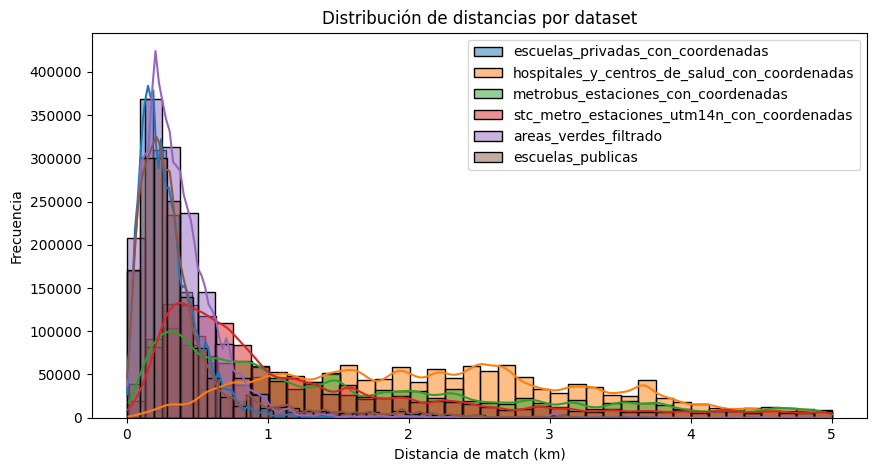

In [55]:


# --- Histograma de distancias ---
plt.figure(figsize=(10,5))
for col in dist_cols:
    sns.histplot(df[col]/1000, label=col.replace("dist_m_", ""), kde=True, bins=40, alpha=0.5)
plt.xlabel("Distancia de match (km)")
plt.ylabel("Frecuencia")
plt.title("Distribución de distancias por dataset")
plt.legend()
plt.show()




In [56]:
# --- Porcentaje global sin match ---
mask_all_nan = df[dist_cols].isna().all(axis=1)
no_match_pct = mask_all_nan.mean() * 100
print(f"\n🚫 Filas sin ningún match: {no_match_pct:.2f}% ({mask_all_nan.sum():,} de {len(df):,})")


🚫 Filas sin ningún match: 0.03% (457 de 1,469,652)


In [57]:
import duckdb
import pandas as pd
from pathlib import Path

output_final = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet")

con = duckdb.connect()

# Muestra aleatoria de 10 filas
sample_df = con.execute(f"""
    SELECT *
    FROM read_parquet('{output_final.as_posix()}')
    USING SAMPLE 10 ROWS
""").fetchdf()

print(f"🧮 Filas: {len(sample_df)}, Columnas: {len(sample_df.columns)}")
print("🔹 Columnas principales:\n", sample_df.columns[:20].tolist(), "...")  # primeras 20
display(sample_df.head(10))


🧮 Filas: 10, Columnas: 236
🔹 Columnas principales:
 ['fid', 'fid_2', 'calle_numero', 'codigo_postal', 'colonia', 'alcaldia', 'sup_terreno', 'sup_construccion', 'anio_construccion', 'instal_esp', 'valor_unitario_suelo', 'valor_suelo', 'cve_vus', 'subsidio', 'calle_norm', 'nombre_limpio', 'clave_delegacion', 'nombre_limpio_l', 'ageb_ENTIDAD', 'ageb_NOM_ENT'] ...


,fid,fid_2,calle_numero,codigo_postal,colonia,alcaldia,sup_terreno,sup_construccion,anio_construccion,instal_esp,valor_unitario_suelo,valor_suelo,cve_vus,subsidio,calle_norm,nombre_limpio,clave_delegacion,nombre_limpio_l,ageb_ENTIDAD,ageb_NOM_ENT,ageb_NOM_MUN,ageb_LOC,ageb_NOM_LOC,ageb_AGEB,ageb_MZA,ageb_POBTOT,ageb_POBFEM,ageb_POBMAS,ageb_P_0A2,ageb_P_0A2_F,ageb_P_0A2_M,ageb_P_18YMAS,ageb_P_18YMAS_F,ageb_P_18YMAS_M,ageb_P_3A5,ageb_P_3A5_F,ageb_P_3A5_M,ageb_P_6A11,ageb_P_6A11_F,ageb_P_6A11_M,ageb_P_8A14,ageb_P_8A14_F,ageb_P_8A14_M,ageb_P_12A14,ageb_P_12A14_F,ageb_P_12A14_M,ageb_P_15A17,ageb_P_15A17_F,ageb_P_15A17_M,ageb_P_18A24,ageb_P_18A24_F,ageb_P_18A24_M,ageb_P_15A49_F,ageb_P_60YMAS,ageb_P_60YMAS_F,ageb_P_60YMAS_M,ageb_POB65_MAS,ageb_P18YM_PB,ageb_P18YM_PB_F,ageb_P18YM_PB_M,ageb_TOTHOG,ageb_HOGJEF_F,ageb_HOGJEF_M,ageb_POBHOG,ageb_PHOGJEF_F,ageb_PHOGJEF_M,ageb_VIVTOT,ageb_TVIVHAB,ageb_TVIVPAR,ageb_VIVPAR_HAB,ageb_VIVPARH_CV,ageb_TVIVPARHAB,ageb_VIVPAR_DES,ageb_VIVPAR_UT,ageb_OCUPVIVPAR,ageb_PROM_OCUP,ageb_PRO_OCUP_C,ageb_VPH_1DOR,ageb_VPH_2YMASD,ageb_VPH_1CUART,ageb_VPH_2CUART,ageb_VPH_3YMASC,ageb_VPH_C_ELEC,ageb_VPH_S_ELEC,ageb_VPH_AGUADV,ageb_VPH_AEASP,ageb_VPH_AGUAFV,ageb_VPH_TINACO,ageb_VPH_CISTER,ageb_VPH_EXCSA,ageb_VPH_LETR,ageb_VPH_DRENAJ,ageb_VPH_NODREN,ageb_VPH_C_SERV,ageb_VPH_NDEAED,ageb_VPH_DSADMA,ageb_VPH_NDACMM,ageb_VPH_SNBIEN,ageb_VPH_REFRI,ageb_VPH_LAVAD,ageb_VPH_HMICRO,ageb_VPH_AUTOM,ageb_VPH_MOTO,ageb_VPH_BICI,ageb_VPH_RADIO,ageb_VPH_TV,ageb_VPH_PC,ageb_VPH_TELEF,ageb_VPH_CEL,ageb_VPH_INTER,ageb_VPH_STVP,ageb_VPH_SPMVPI,ageb_VPH_CVJ,ageb_VPH_SINRTV,ageb_VPH_SINLTC,ageb_VPH_SINCINT,ageb_VPH_SINTIC,ageb_key,ageb_ENTIDAD_fm,ageb_MUN_fm,ageb_LOC_fm,ageb_AGEB_fm,ageb_MZA_fm,ageb_CVEVIAL,ageb_CVESEG,ageb_CVEFT,ageb_NOMVIAL,ageb_TIPOVIAL,ageb_CVEVIAL1,ageb_CVESEG1,ageb_CVEREF1,ageb_TIPOVR1,ageb_NOMREF1,ageb_CVEVIAL2,ageb_CVESEG2,ageb_CVEREF2,ageb_TIPOVR2,ageb_NOMREF2,ageb_CVEVIAL3,ageb_CVESEG3,ageb_CVEREF3,ageb_TIPOVR3,ageb_NOMREF3,ageb_lon,ageb_lat,ageb_MUN,ageb_nomref1_l,ageb_block,ageb_len,matched_NOMREF1,similaridad,lon_wgs84,lat_wgs84,nombre_escuelas_privadas_con_coordenadas,nivel_escuelas_privadas_con_coordenadas,turno_escuelas_privadas_con_coordenadas,sstnmnt_escuelas_privadas_con_coordenadas,domicil_escuelas_privadas_con_coordenadas,ubicacn_escuelas_privadas_con_coordenadas,colonia_escuelas_privadas_con_coordenadas,alcaldi_escuelas_privadas_con_coordenadas,longitud_escuelas_privadas_con_coordenadas,latitud_escuelas_privadas_con_coordenadas,dist_m_escuelas_privadas_con_coordenadas,_id_hospitales_y_centros_de_salud_con_coordenadas,id_hospitales_y_centros_de_salud_con_coordenadas,nombre_hospitales_y_centros_de_salud_con_coordenadas,titular_hospitales_y_centros_de_salud_con_coordenadas,cordnds_hospitales_y_centros_de_salud_con_coordenadas,geopont_hospitales_y_centros_de_salud_con_coordenadas,longitud_hospitales_y_centros_de_salud_con_coordenadas,latitud_hospitales_y_centros_de_salud_con_coordenadas,dist_m_hospitales_y_centros_de_salud_con_coordenadas,SISTEMA_metrobus_estaciones_con_coordenadas,NOMBRE_metrobus_estaciones_con_coordenadas,LINEA_metrobus_estaciones_con_coordenadas,EST_metrobus_estaciones_con_coordenadas,CVE_EOD17_metrobus_estaciones_con_coordenadas,TIPO_metrobus_estaciones_con_coordenadas,ALCALDIAS_metrobus_estaciones_con_coordenadas,AÑO_metrobus_estaciones_con_coordenadas,CVE_EST_metrobus_estaciones_con_coordenadas,longitud_metrobus_estaciones_con_coordenadas,latitud_metrobus_estaciones_con_coordenadas,dist_m_metrobus_estaciones_con_coordenadas,SISTEMA_stc_metro_estaciones_utm14n_con_coordenadas,NOMBRE_stc_metro_estaciones_utm14n_con_coordenadas,LINEA_stc_metro_estaciones_utm14n_con_coordenadas,EST_stc_metro_estaciones_utm14n_con_coordenadas,CVE_EST_stc_metro_estaciones_utm14n_con_coordenadas,CVE_EOD17_stc_metro_estaciones_utm14n_con_coordenadas,TIPO_stc_metro_estaciones_utm14n_con_coordenadas,ALCALDIAS_stc_metro_estaciones_utm14n_con_coordenadas,AÑO_stc_metro_estaciones_utm14n_con_coordenadas,lon

In [59]:
import duckdb
import pandas as pd
from pathlib import Path

# Ruta del parquet final
output_final = Path("/Users/eaha/Documents/TFM/mlops-repo/data/processed/AGEBvsCatastral/Merged_Delegacion_final_balltree.parquet")

con = duckdb.connect()

# 1️⃣ Detectar columnas relevantes
cols_df = con.execute(f"DESCRIBE SELECT * FROM read_parquet('{output_final.as_posix()}')").fetchdf()
cols = cols_df["column_name"].tolist()


target_cols = [c for c in cols if any(k in c.lower() for k in ["lat", "lon", "longitud", "latitud"])]
print(f"📋 Columnas de coordenadas detectadas: {len(target_cols)}")
for c in target_cols:
    print(" -", c)

# 2️⃣ Calcular porcentaje de nulos por columna (eficiente)
results = []
for col in target_cols:
    q = f"""
        SELECT 
            COUNT(*) AS total,
            SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS nulos
        FROM read_parquet('{output_final.as_posix()}')
    """
    total, nulos = con.execute(q).fetchone()
    pct_null = nulos / total * 100
    results.append({"columna": col, "pct_nulos": pct_null})

# 3️⃣ Mostrar resumen ordenado
df_nulos = pd.DataFrame(results).sort_values("pct_nulos", ascending=True).reset_index(drop=True)

print("\n📈 Porcentaje de valores nulos por columna de coordenadas:")
print(df_nulos.round(3))


📋 Columnas de coordenadas detectadas: 19
 - colonia
 - ageb_lon
 - ageb_lat
 - lon_wgs84
 - lat_wgs84
 - colonia_escuelas_privadas_con_coordenadas
 - longitud_escuelas_privadas_con_coordenadas
 - latitud_escuelas_privadas_con_coordenadas
 - longitud_hospitales_y_centros_de_salud_con_coordenadas
 - latitud_hospitales_y_centros_de_salud_con_coordenadas
 - longitud_metrobus_estaciones_con_coordenadas
 - latitud_metrobus_estaciones_con_coordenadas
 - longitud_stc_metro_estaciones_utm14n_con_coordenadas
 - latitud_stc_metro_estaciones_utm14n_con_coordenadas
 - latitud_areas_verdes_filtrado
 - longitud_areas_verdes_filtrado
 - colonia_escuelas_publicas
 - latitud_escuelas_publicas
 - longitud_escuelas_publicas

📈 Porcentaje de valores nulos por columna de coordenadas:
                                              columna  pct_nulos
0                                             colonia      0.000
1                                            ageb_lon      0.000
2                               